In [2]:
import numpy as np
import pandas as pd

In [3]:
state_probs = pd.read_csv("state_probs_df.csv")
data_log = pd.read_csv("close_data_log.csv")

In [4]:
data_log.columns

Index(['TSX_Composite', 'Canada_Financials_Index', 'Crude_Oil_Futures',
       'Gold_Futures', 'Copper_Futures', 'USD_to_CAD',
       'Canada_Corporate_Bonds', 'Canada_Government_Bonds', 'US_oil_gas',
       'Global_Materials', 'US_Real_Estate', 'SP_500', 'Date'],
      dtype='object')

In [5]:

data = state_probs.join(data_log[["TSX_Composite", "Crude_Oil_Futures", "Gold_Futures", "Copper_Futures", "SP_500"]], how="inner").drop(columns=["Date"])
data.columns

Index(['TSX_Composite_1', 'TSX_Composite_2', 'TSX_Composite_3',
       'Crude_Oil_Futures_1', 'Crude_Oil_Futures_2', 'Crude_Oil_Futures_3',
       'Gold_Futures_1', 'Gold_Futures_2', 'Gold_Futures_3',
       'Copper_Futures_1', 'Copper_Futures_2', 'Copper_Futures_3', 'SP_500_1',
       'SP_500_2', 'SP_500_3', 'TSX_Composite', 'Crude_Oil_Futures',
       'Gold_Futures', 'Copper_Futures', 'SP_500'],
      dtype='object')

In [11]:
lookback = 10
forecast_horizon = 2
train_size = int(len(data) * 0.6)
validation_size = int(len(data) * 0.2)
test_size = len(data) - train_size - validation_size
def compute_train_val_test_splits(data, lookback, forecast_horizon):
    train_size = int(len(data) * 0.6)
    validation_size = int(len(data) * 0.2)
    test_size = len(data) - train_size - validation_size

    target_cols = ["TSX_Composite_1", "TSX_Composite_2", "TSX_Composite_3"]
    train_end = train_size
    val_end = train_size + validation_size
    test_end = len(data) -1

    # Train
    X_train, Y_train = [], []
    for i in range(lookback, train_end - forecast_horizon + 1):
        X_train.append(data.iloc[i - lookback:i].values)
        Y_train.append(data.iloc[i + forecast_horizon-1][target_cols].values)
    X_train = np.array(X_train)
    Y_train = np.array(Y_train)
    # Validation
    X_val, Y_val = [], []
    for i in range(train_end + lookback, val_end - forecast_horizon + 1):
        X_val.append(data.iloc[i - lookback:i].values)
        Y_val.append(data.iloc[i + forecast_horizon-1][target_cols].values)
    X_val = np.array(X_val)
    Y_val = np.array(Y_val)

    # Test
    X_test, Y_test = [], []
    for i in range(val_end + lookback, test_end - forecast_horizon + 1):
        X_test.append(data.iloc[i - lookback:i].values)
        Y_test.append(data.iloc[i + forecast_horizon-1][target_cols].values)
    X_test = np.array(X_test)
    Y_test = np.array(Y_test)

    return X_train, Y_train, X_val, Y_val, X_test, Y_test


In [7]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers
from tensorflow.keras.metrics import CategoricalAccuracy, CategoricalCrossentropy

lookback = 10
forecast_horizon = 2
X_train, Y_train, X_val, Y_val, X_test, Y_test = compute_train_val_test_splits(data, lookback, forecast_horizon)

model = Sequential([layers.Input(X_train.shape[1::]),
        layers.LSTM(64),
        layers.Dense(32, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(32, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(3, activation='softmax')])

model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=[CategoricalAccuracy(name='accuracy'), CategoricalCrossentropy(name='cross_entropy')]
)

history = model.fit(X_train, Y_train, epochs=10, validation_data=(X_val, Y_val), verbose=0)


2026-01-19 16:42:46.958205: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2026-01-19 16:42:55.242309: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1768869775.915726 3022277 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1768869776.320772 3022277 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1768869778.201766 3022277 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

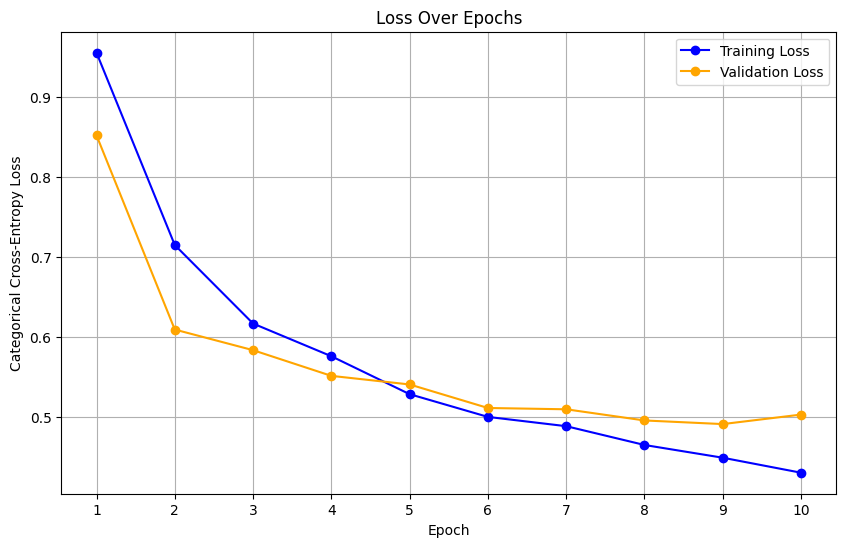

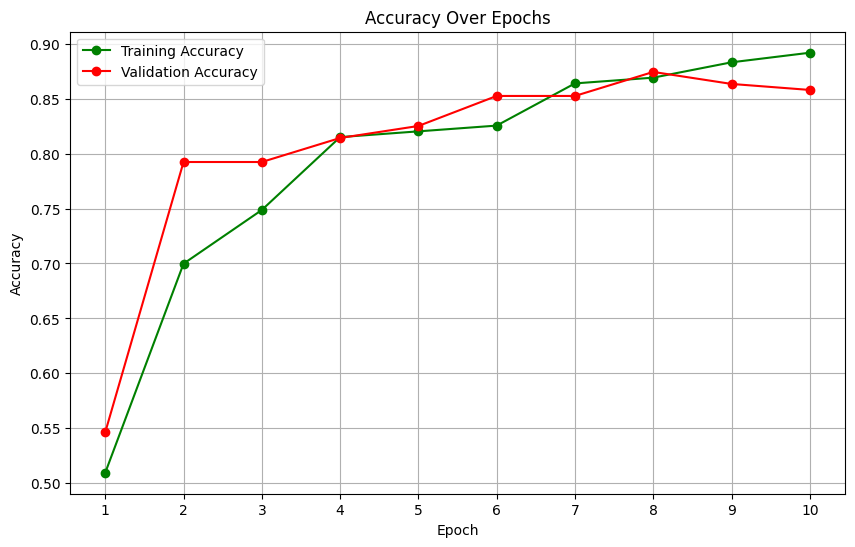

In [8]:
import matplotlib.pyplot as plt

def plot_training_history(history):
    epochs = range(1, len(history.history['loss']) + 1)
    
    # Plot Loss
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, history.history['loss'], label='Training Loss', marker='o', color='blue')
    plt.plot(epochs, history.history['val_loss'], label='Validation Loss', marker='o', color='orange')
    plt.title('Loss Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Categorical Cross-Entropy Loss')
    plt.legend()
    plt.grid(True)
    plt.xticks(epochs)
    plt.show()
    
    # Plot Accuracy
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, history.history['accuracy'], label='Training Accuracy', marker='o', color='green')
    plt.plot(epochs, history.history['val_accuracy'], label='Validation Accuracy', marker='o', color='red')
    plt.title('Accuracy Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    plt.xticks(epochs)
    plt.show()

# Call the function after training
plot_training_history(history)

/tmp/ipykernel_3022277/3175366744.py:54: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


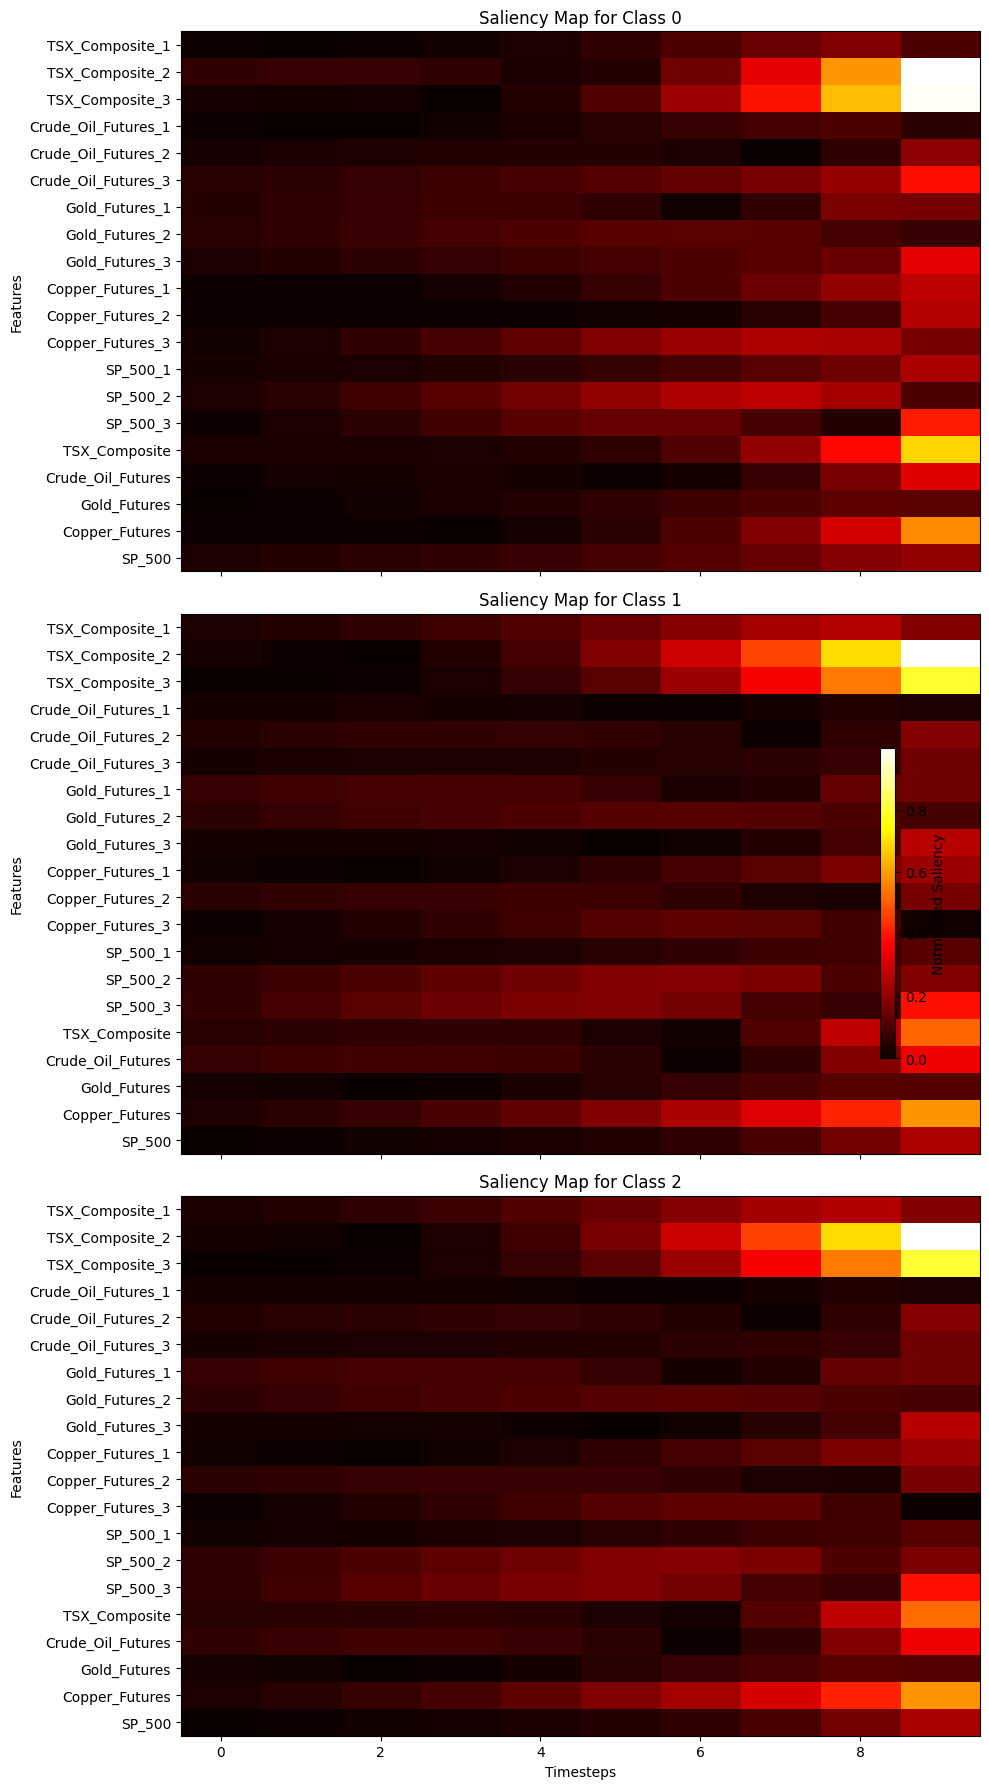

In [9]:
# Saliency Map Computation and Plotting
# Assuming the model is trained and 'data' provides feature_names
feature_names = data.columns.tolist()  # List of feature names

# Select a sample input (e.g., the first from validation set)
sample_input = X_val[2:3]  # Shape: (1, timesteps, features)

# Initialize a list to store saliency maps for each class
saliency_maps = []

for target_class in range(3):  # For classes 0, 1, 2
    with tf.GradientTape() as tape:
        # Ensure input is a Tensor and watched by the tape
        input_tensor = tf.convert_to_tensor(sample_input, dtype=tf.float32)
        tape.watch(input_tensor)
        
        # Get model predictions
        predictions = model(input_tensor)
        
        # Select the output for the target class
        class_output = predictions[:, target_class]

    # Compute gradients w.r.t. input
    gradients = tape.gradient(class_output, input_tensor)
    
    # Take absolute values for saliency (importance)
    saliency_map = tf.abs(gradients).numpy()[0]  # Shape: (timesteps, features)
    
    # Transpose for features on y-axis
    saliency_map_transposed = saliency_map.T  # Shape: (features, timesteps)
    
    # Normalize for visualization
    saliency_map_transposed = (saliency_map_transposed - saliency_map_transposed.min()) / \
                              (saliency_map_transposed.max() - saliency_map_transposed.min() + 1e-8)
    
    saliency_maps.append(saliency_map_transposed)

# Plot all three saliency maps stacked vertically
fig, axs = plt.subplots(3, 1, figsize=(10, 18), sharex=True)  # 3 rows, 1 column

for i, ax in enumerate(axs):
    im = ax.imshow(saliency_maps[i], cmap='hot', aspect='auto')
    ax.set_title(f'Saliency Map for Class {i}')
    ax.set_ylabel('Features')
    ax.set_yticks(range(len(feature_names)))
    ax.set_yticklabels(feature_names)
    
    if i == 2:  # Only label x-axis on the bottom plot
        ax.set_xlabel('Timesteps')

# Add a shared colorbar
fig.colorbar(im, ax=axs, orientation='vertical', fraction=0.02, pad=0.04, label='Normalized Saliency')

plt.tight_layout()
plt.show()

Compute LSTM loss for 6 step forecast horizon

In [88]:
max_horizon = 10
state_losses = np.full((test_size, max_horizon), np.nan)
predictions = np.full((test_size, max_horizon, 3), np.nan)
ground_truth = np.full((test_size, max_horizon, 3), np.nan)
last_state = np.full((test_size, max_horizon, 3), np.nan)
for forecast_horizon in range(1, max_horizon + 1):
    lookback = 10
    # Train
    X_train, Y_train, X_val, Y_val, X_test, Y_test = compute_train_val_test_splits(data, lookback, forecast_horizon)

    model = Sequential([layers.Input(X_train.shape[1::]),
            layers.LSTM(64),
            layers.Dense(32, activation='relu'),
            layers.Dropout(0.3),
            layers.Dense(32, activation='relu'),
            layers.Dropout(0.3),
            layers.Dense(3, activation='softmax')])

    model.compile(
        loss='categorical_crossentropy',
        optimizer='adam',
        metrics=[CategoricalAccuracy(name='accuracy'), CategoricalCrossentropy(name='cross_entropy')]
    )

    history = model.fit(X_train, Y_train, epochs=20, verbose=0)

    Y_hat = model.predict(X_test)
    eps = 1e-15
    loss = -np.sum(Y_test * np.log(np.clip(Y_hat, eps, 1.0)), axis=1)
    state_losses[0:len(loss), forecast_horizon - 1] = loss
    predictions[0:len(loss), forecast_horizon - 1, :] = Y_hat
    ground_truth[0:len(loss), forecast_horizon - 1, :] = Y_test
    last_state[0:len(loss), forecast_horizon - 1, :] = X_test[:, -1, :3]



6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


In [89]:
# Compute statistics for each column of state_losses
stats = {
    'mean': np.nanmean(state_losses, axis=0),
    'median': np.nanmedian(state_losses, axis=0),
    'P25': np.nanpercentile(state_losses, 25, axis=0),
    'P75': np.nanpercentile(state_losses, 75, axis=0),
    'max': np.nanmax(state_losses, axis=0),
    'min': np.nanmin(state_losses, axis=0)
}

# Convert to DataFrame for better display
stats_df = pd.DataFrame(stats, index=[i+1 for i in range(state_losses.shape[1])])
stats_df

,mean,median,P25,P75,max,min
1,0.425875,0.343718,0.142902,0.650156,1.432248,0.048828
2,0.465438,0.397120,0.177847,0.666628,1.590797,0.063750
3,0.558271,0.456939,0.184807,0.761002,2.343651,0.048885
4,0.753584,0.551009,0.209300,0.954005,3.529121,0.036459
5,0.757401,0.563561,0.222116,0.988892,3.657225,0.045336
6,0.709953,0.587201,0.315146,0.867735,3.177478,0.082089
7,0.809325,0.617286,0.298553,0.946090,4.064885,0.066311
8,0.773096,0.566257,0.335709,1.037683,3.012355,0.067467
9,0.869304,0.697396,0.340036,1.093372,2.779355,0.051534
10,0.822643,0.703364,0.404934,1.047839,2.686447,0.065063


In [90]:
hmm_states_df = pd.read_csv("hmm_stats_df.csv").set_index('Horizon')
hmm_states_df

,mean,median,P25,P75,max,min
Horizon,,,,,,
1,0.564935,0.486101,0.255248,0.754198,1.870970,0.066080
2,0.613440,0.540793,0.313817,0.823104,1.765886,0.122412
3,0.647665,0.557777,0.372511,0.866316,1.708039,0.165387
4,0.673310,0.585635,0.405147,0.869711,1.616012,0.204881
5,0.692428,0.618093,0.434987,0.898606,1.758840,0.272055
6,0.705257,0.635753,0.465917,0.881576,1.813326,0.306991
7,0.713219,0.661398,0.477779,0.840335,1.794145,0.338480
8,0.716846,0.677708,0.497952,0.851244,1.737189,0.341420
9,0.719356,0.685347,0.523949,0.832881,1.671376,0.372906


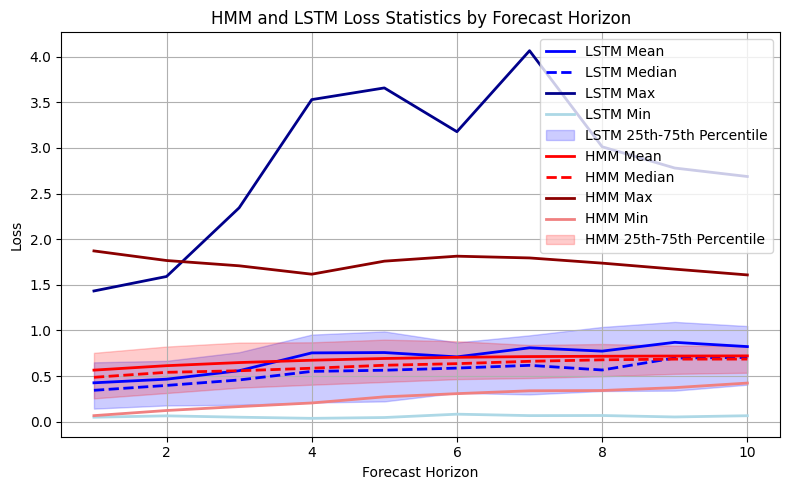

In [91]:
fig, ax = plt.subplots(figsize=(8, 5))

horizons = stats_df.index

# Plot LSTM stats
ax.plot(horizons, stats_df['mean'], label='LSTM Mean', color='blue', linewidth=2)
ax.plot(horizons, stats_df['median'], label='LSTM Median', color='blue', linestyle='--', linewidth=2)
ax.plot(horizons, stats_df['max'], label='LSTM Max', color='darkblue', linewidth=2)
ax.plot(horizons, stats_df['min'], label='LSTM Min', color='lightblue', linewidth=2)
ax.fill_between(horizons, stats_df['P25'], stats_df['P75'], color='blue', alpha=0.2, label='LSTM 25th-75th Percentile')

# plot HMM stats
horizons = hmm_states_df.index
ax.plot(horizons, hmm_states_df['mean'], label='HMM Mean', color='red', linewidth=2)
ax.plot(horizons, hmm_states_df['median'], label='HMM Median', color='red', linestyle='--', linewidth=2)
ax.plot(horizons, hmm_states_df['max'], label='HMM Max', color='darkred', linewidth=2)
ax.plot(horizons, hmm_states_df['min'], label='HMM Min', color='lightcoral', linewidth=2)
ax.fill_between(horizons, hmm_states_df['P25'], hmm_states_df['P75'], color='red', alpha=0.2, label='HMM 25th-75th Percentile')

ax.set_xlabel('Forecast Horizon')
ax.set_ylabel('Loss')
ax.set_title('HMM and LSTM Loss Statistics by Forecast Horizon')
ax.legend()
ax.grid(True)
plt.tight_layout()
plt.show()

In [58]:
import rpy2.robjects as robjects
import pandas as pd
import numpy as np

# Helper function to convert R data.frame to pandas DataFrame
def r_to_df(r_df):
    return pd.DataFrame({name: np.array(r_df.rx2(name)) for name in r_df.names})

# Read the RDS files using rpy2
readRDS = robjects.r['readRDS']

hmm_stats_r = readRDS('hmm_stats_df.rds')
hmm_stats_df = r_to_df(hmm_stats_r)

hmm_state_losses = np.array(readRDS('hmm_state_losses.rds'))
hmm_predictions = np.array(readRDS('hmm_predictions.rds'))
hmm_ground_truth = np.array(readRDS('hmm_ground_truth.rds'))
lstm_stats_df = stats_df
lstm_state_losses = state_losses
lstm_predictions = predictions
lstm_ground_truth = ground_truth
loss_comparison = pd.DataFrame(hmm_state_losses - lstm_state_losses)
loss_comparison.describe()

/tmp/ipykernel_3022277/3979833542.py:22: RuntimeWarning: invalid value encountered in subtract
  loss_comparison = pd.DataFrame(hmm_state_losses - lstm_state_losses)


,0,1,2,3,4,5,6,7,8,9
count,185.000000,184.000000,183.000000,182.000000,181.000000,180.000000,179.000000,178.000000,177.000000,176.000000
mean,0.168179,0.138602,0.116667,0.019703,-0.052857,-0.115963,-0.112510,-0.194012,-0.026514,-0.103787
std,0.451877,0.526067,0.540392,0.649031,0.709079,0.727735,0.769799,0.783053,0.543420,0.567545
min,-0.551107,-0.990467,-1.009713,-1.867946,-2.859864,-2.122326,-2.196368,-2.697178,-1.775308,-2.595193
25%,-0.180640,-0.219842,-0.213895,-0.321556,-0.306401,-0.455710,-0.363152,-0.512326,-0.288885,-0.405962
50%,0.093341,0.090399,0.071487,0.082827,0.068012,0.015131,0.053376,0.003059,0.077090,-0.003607
75%,0.390408,0.466948,0.438652,0.439104,0.415574,0.353141,0.343079,0.294886,0.275693,0.256318
max,1.645628,1.644847,1.573325,1.453858,1.400348,1.383698,1.498016,1.182179,1.121412,1.126175


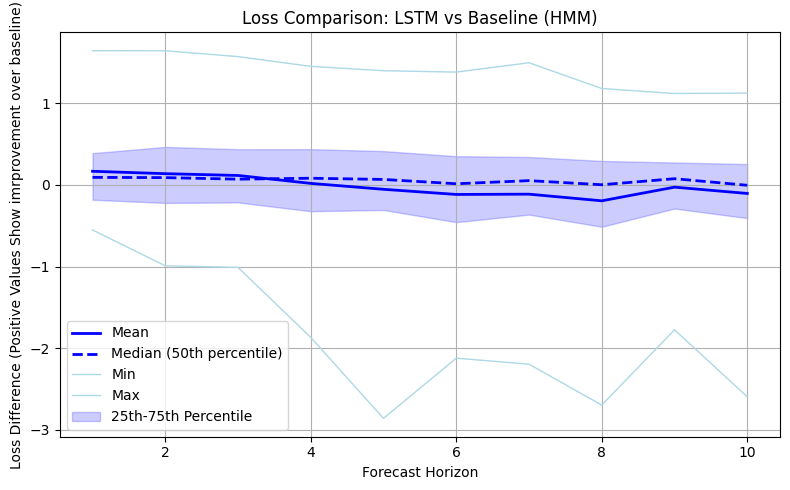

In [155]:
fig, ax = plt.subplots(figsize=(8, 5))

horizons = np.arange(1, loss_comparison.shape[1] + 1)

# Compute statistics
mean = loss_comparison.mean(axis=0)
median = loss_comparison.median(axis=0)
p25 = loss_comparison.quantile(0.25, axis=0)
p75 = loss_comparison.quantile(0.75, axis=0)
min_ = loss_comparison.min(axis=0)
max_ = loss_comparison.max(axis=0)

# Plot mean (solid)
ax.plot(horizons, mean, label='Mean', color='blue', linewidth=2)
# Plot median (dashed)
ax.plot(horizons, median, label='Median (50th percentile)', color='blue', linestyle='--', linewidth=2)
# Plot min/max (light solid)
ax.plot(horizons, min_, label='Min', color='lightblue', linewidth=1)
ax.plot(horizons, max_, label='Max', color='lightblue', linewidth=1)
# Fill between 25th and 75th percentile
ax.fill_between(horizons, p25, p75, color='blue', alpha=0.2, label='25th-75th Percentile')

ax.set_xlabel('Forecast Horizon')
ax.set_ylabel('Loss Difference (Positive Values Show imrprovement over baseline)')
ax.set_title('Loss Comparison: LSTM vs Baseline (HMM)')
ax.legend()
ax.grid(True)
plt.tight_layout()
plt.show()

In [156]:
np.argmin(np.mean(lstm_state_losses[0:184, :], axis=1))

np.int64(176)

In [157]:
np.argmax(np.mean(lstm_state_losses[0:184, :], axis=1))

np.int64(176)

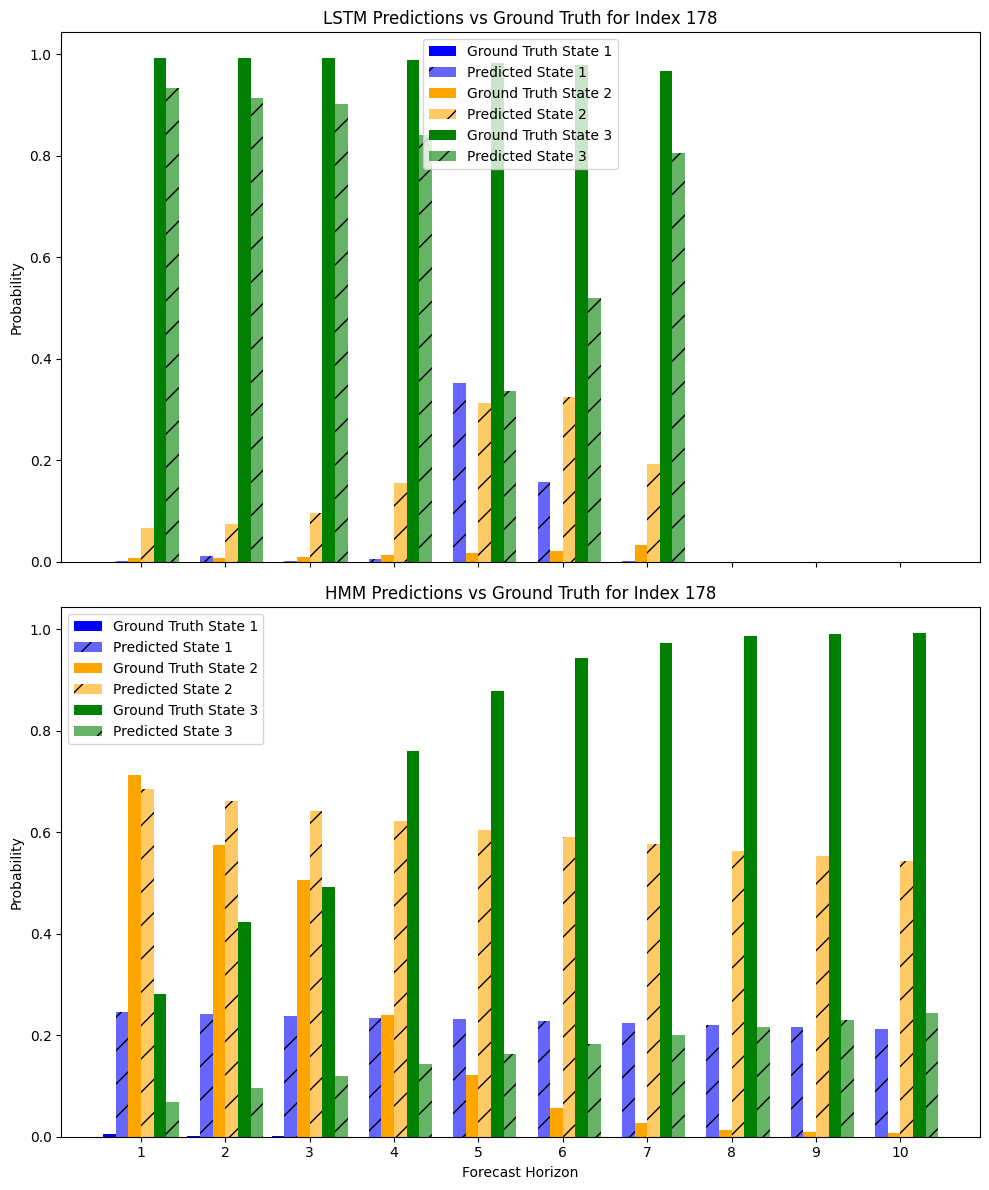

In [158]:
import numpy as np
import matplotlib.pyplot as plt

index = 178 # 108, 178, 120
# Assuming lstm_predictions, lstm_ground_truth, hmm_predictions, and hmm_ground_truth are defined as 3D arrays (e.g., shape: samples, horizons, states)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 12), sharex=True)
forecast_range = np.arange(lstm_predictions.shape[1])
bar_width = 0.15

# Plot for LSTM on ax1
for state, color in zip(range(3), ['blue', 'orange', 'green']):
    offset = state * (bar_width * 2)
    # Plot ground truth (solid, opaque)
    ax1.bar(
        forecast_range + offset,
        lstm_ground_truth[index, :, state],
        width=bar_width,
        label=f'Ground Truth State {state+1}',
        color=color,
        alpha=1
    )
    # Plot predictions (with striped pattern for distinction)
    ax1.bar(
        forecast_range + offset + bar_width,
        lstm_predictions[index, :, state],
        width=bar_width,
        label=f'Predicted State {state+1}',
        color=color,
        alpha=0.6,
        hatch='/'
    )

# Avoid duplicate labels in legend for ax1
handles1, labels1 = ax1.get_legend_handles_labels()
unique1 = dict(zip(labels1, handles1))
ax1.legend(unique1.values(), unique1.keys())
ax1.set_ylabel('Probability')
ax1.set_title(f'LSTM Predictions vs Ground Truth for Index {index}')

# Plot for HMM on ax2
for state, color in zip(range(3), ['blue', 'orange', 'green']):
    offset = state * (bar_width * 2)
    # Plot ground truth (solid, opaque)
    ax2.bar(
        forecast_range + offset,
        hmm_ground_truth[index, :, state],
        width=bar_width,
        label=f'Ground Truth State {state+1}',
        color=color,
        alpha=1
    )
    # Plot predictions (with striped pattern for distinction)
    ax2.bar(
        forecast_range + offset + bar_width,
        hmm_predictions[index, :, state],
        width=bar_width,
        label=f'Predicted State {state+1}',
        color=color,
        alpha=0.6,
        hatch='/'
    )

# Avoid duplicate labels in legend for ax2
handles2, labels2 = ax2.get_legend_handles_labels()
unique2 = dict(zip(labels2, handles2))
ax2.legend(unique2.values(), unique2.keys())
ax2.set_xlabel('Forecast Horizon')
ax2.set_ylabel('Probability')
ax2.set_title(f'HMM Predictions vs Ground Truth for Index {index}')

# Set x-ticks centered for each group
xtick_positions = forecast_range + bar_width * 2.5
ax2.set_xticks(xtick_positions)
ax2.set_xticklabels([str(i+1) for i in forecast_range])

plt.tight_layout()
plt.show()

## Testing combined transition probability model

In [62]:
lstm_predictions.shape

(196, 10, 3)

In [147]:
# Transition matrix from the HMM
transition_matrix = np.array([[0.974, 0.026, 0.000],
                              [0.004, 0.951, 0.045],
                              [0.000, 0.051, 0.949]])

alpha = 0.2
trials = lstm_predictions.shape[0]
horizons = lstm_predictions.shape[1]
combined_transitions = np.zeros((trials, horizons, 3, 3))
for trial in range(trials):
    for horizon in range(horizons):
        #_alpha = (alpha + 0) / (horizon + 0 + 1)
        combined = np.tile(lstm_predictions[trial, horizon, :], (3, 1)) * alpha + transition_matrix * (1 - alpha)
        combined_transitions[trial, horizon, :, :] = combined

combined_predictions = np.zeros((trials, horizons, 3))
for trial in range(trials):
    for horizon in range(horizons):
        if horizon == 0:
            last_prediction = last_state[trial, 0, :]
        else:
            last_prediction = combined_predictions[trial, horizon - 1, :]
        next_prediction = last_prediction @ combined_transitions[trial, horizon, :, :]
        combined_predictions[trial, horizon, :] = next_prediction

In [148]:
# Compute cross-entropy loss per trial and per horizon between combined_predictions and lstm_ground_truth
eps = 1e-15  # for numerical stability
combined_cross_entropy_loss = -np.sum(
    lstm_ground_truth * np.log(np.clip(combined_predictions, eps, 1.0)),
    axis=2
)  # shape: (trials, horizons)

combined_cross_entropy_loss.shape

(196, 10)

In [149]:
# Compute statistics for each column of state_losses
combined_stats = {
    'mean': np.nanmean(combined_cross_entropy_loss, axis=0),
    'median': np.nanmedian(combined_cross_entropy_loss, axis=0),
    'P25': np.nanpercentile(combined_cross_entropy_loss, 25, axis=0),
    'P75': np.nanpercentile(combined_cross_entropy_loss, 75, axis=0),
    'max': np.nanmax(combined_cross_entropy_loss, axis=0),
    'min': np.nanmin(combined_cross_entropy_loss, axis=0)
}

# Convert to DataFrame for better display
combined_stats = pd.DataFrame(combined_stats, index=[i+1 for i in range(combined_cross_entropy_loss.shape[1])])
combined_stats

,mean,median,P25,P75,max,min
1,0.378272,0.372063,0.144061,0.615964,0.820731,0.066897
2,0.427290,0.420060,0.183777,0.619450,1.077611,0.103707
3,0.479729,0.455980,0.230659,0.651924,1.262902,0.134217
4,0.532079,0.478355,0.262870,0.690579,1.490291,0.156413
5,0.581730,0.523891,0.308698,0.719759,1.735610,0.159745
6,0.626394,0.552419,0.355537,0.777530,1.860899,0.167044
7,0.659617,0.590837,0.371631,0.820870,1.901997,0.188262
8,0.693577,0.612764,0.402596,0.847016,1.890412,0.190028
9,0.695705,0.645601,0.433759,0.872503,1.796617,0.206727
10,0.716162,0.673409,0.469214,0.929866,1.706580,0.206785


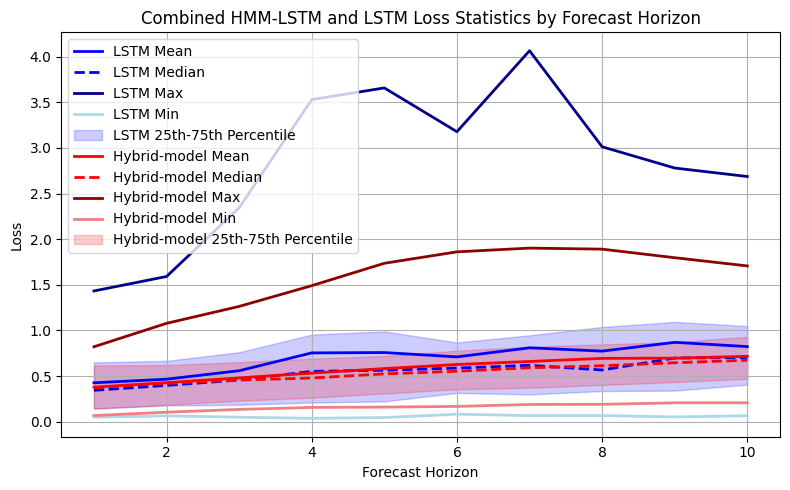

In [150]:
fig, ax = plt.subplots(figsize=(8, 5))

horizons = stats_df.index

# Plot LSTM stats
ax.plot(horizons, stats_df['mean'], label='LSTM Mean', color='blue', linewidth=2)
ax.plot(horizons, stats_df['median'], label='LSTM Median', color='blue', linestyle='--', linewidth=2)
ax.plot(horizons, stats_df['max'], label='LSTM Max', color='darkblue', linewidth=2)
ax.plot(horizons, stats_df['min'], label='LSTM Min', color='lightblue', linewidth=2)
ax.fill_between(horizons, stats_df['P25'], stats_df['P75'], color='blue', alpha=0.2, label='LSTM 25th-75th Percentile')

# plot HMM stats
horizons = combined_stats.index
ax.plot(horizons, combined_stats['mean'], label='Hybrid-model Mean', color='red', linewidth=2)
ax.plot(horizons, combined_stats['median'], label='Hybrid-model Median', color='red', linestyle='--', linewidth=2)
ax.plot(horizons, combined_stats['max'], label='Hybrid-model Max', color='darkred', linewidth=2)
ax.plot(horizons, combined_stats['min'], label='Hybrid-model Min', color='lightcoral', linewidth=2)
ax.fill_between(horizons, combined_stats['P25'], combined_stats['P75'], color='red', alpha=0.2, label='Hybrid-model 25th-75th Percentile')

# # plot HMM stats
# horizons = hmm_states_df.index
# ax.plot(horizons, hmm_states_df['mean'], label='HMM Mean', color='green', linewidth=2)
# ax.plot(horizons, hmm_states_df['median'], label='HMM Median', color='green', linestyle='--', linewidth=2)
# ax.plot(horizons, hmm_states_df['max'], label='HMM Max', color='darkgreen', linewidth=2)
# ax.plot(horizons, hmm_states_df['min'], label='HMM Min', color='lightgreen', linewidth=2)
# ax.fill_between(horizons, hmm_states_df['P25'], hmm_states_df['P75'], color='green', alpha=0.2, label='HMM 25th-75th Percentile')

ax.set_xlabel('Forecast Horizon')
ax.set_ylabel('Loss')
ax.set_title('Combined HMM-LSTM and LSTM Loss Statistics by Forecast Horizon')
ax.legend()
ax.grid(True)
plt.tight_layout()
plt.show()

## Test using dropout layers to determine the model's predictive uncertainty.



In [ ]:
# Define the mc_dropout_predictions function
def mc_dropout_predictions(model, X, Y_true=None, num_samples=100):
    predictions = np.stack([model(X, training=True) for _ in range(num_samples)], axis=0)
    num_examples, num_classes = predictions.shape[1], predictions.shape[2]
    mean_probs = np.mean(predictions, axis=0)
    epsilon = 1e-10
    entropy = -np.sum(mean_probs * np.log(mean_probs + epsilon), axis=1, keepdims=True)
    std_dev = np.std(predictions, axis=0)
    mean_std_dev = np.mean(std_dev, axis=1, keepdims=True)
    max_std_dev = np.max(std_dev, axis=1, keepdims=True)
    per_sample_loss = np.zeros((num_examples, 1))
    if Y_true is not None:
        Y_true = np.asarray(Y_true)
        cross_entropy = -np.sum(Y_true * np.log(mean_probs + epsilon), axis=1, keepdims=True)
        per_sample_loss = cross_entropy
    df = pd.DataFrame()
    df[[f'Class_{i}_True' for i in range(num_classes)]] = Y_true
    df[[f'Class_{i}_Prob' for i in range(num_classes)]] = mean_probs
    df['Predictive_Entropy'] = entropy
    for i in range(num_classes):
        df[f'Class_{i}_StdDev'] = std_dev[:, i]
    df['Mean_StdDev'] = mean_std_dev
    df['Max_StdDev'] = max_std_dev
    df['Per_Sample_Loss'] = per_sample_loss

    return df

In [ ]:
lookback = 10
forecast_horizon = 1
X_train, Y_train, X_val, Y_val, X_test, Y_test = compute_train_val_test_splits(data, lookback, forecast_horizon)

model = Sequential([layers.Input(X_train.shape[1::]),
        layers.LSTM(64),
        layers.Dense(32, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(32, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(3, activation='softmax')])

model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=[CategoricalAccuracy(name='accuracy'), CategoricalCrossentropy(name='cross_entropy')]
)

model.fit(X_train, Y_train, epochs=10, validation_data=(X_val, Y_val), verbose=0)

uncertainty_df = mc_dropout_predictions(model, X_test, Y_test, num_samples=100)

Correlation matrix:
                     Per_Sample_Loss  Mean_StdDev  Max_StdDev  \
Per_Sample_Loss            1.000000     0.686749    0.658616   
Mean_StdDev                0.686749     1.000000    0.985273   
Max_StdDev                 0.658616     0.985273    1.000000   
Predictive_Entropy         0.742528     0.938509    0.890744   

                    Predictive_Entropy  
Per_Sample_Loss               0.742528  
Mean_StdDev                   0.938509  
Max_StdDev                    0.890744  
Predictive_Entropy            1.000000  


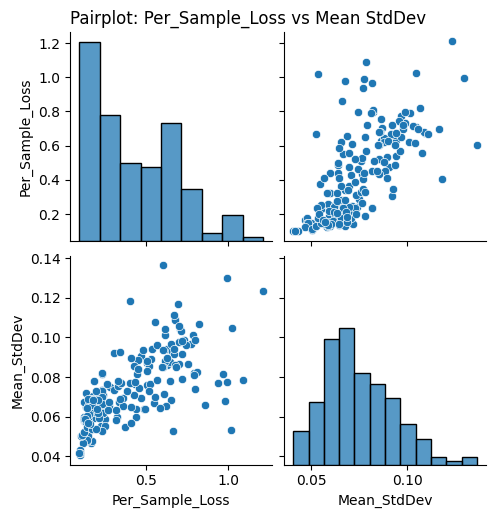

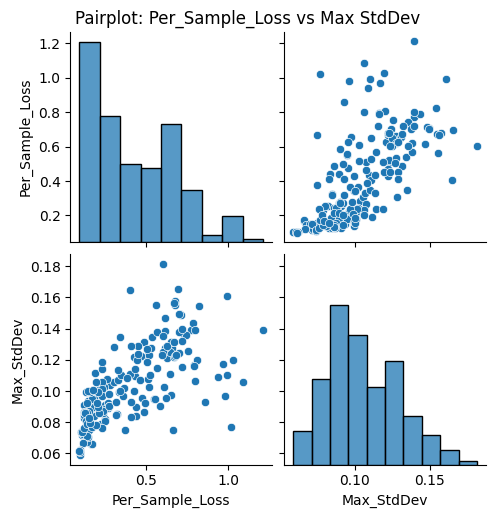

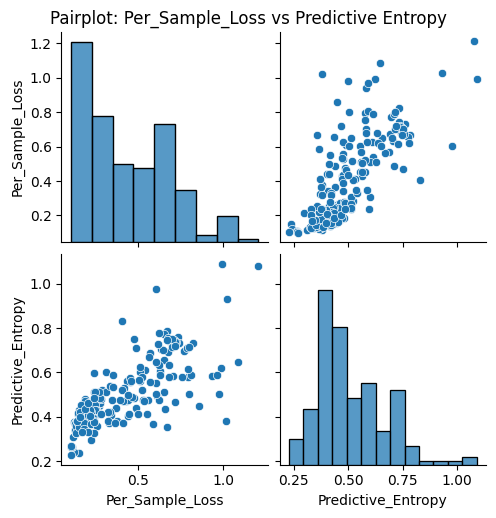

In [ ]:
import seaborn as sns

import matplotlib.pyplot as plt

# Check correlation between Per_Sample_Loss, Mean_StdDev, and Max_StdDev
corr = uncertainty_df[['Per_Sample_Loss', 'Mean_StdDev', 'Max_StdDev', 'Predictive_Entropy' ]].corr()
print("Correlation matrix:\n", corr)

# Pairplot for visual inspection
sns.pairplot(uncertainty_df[['Per_Sample_Loss', 'Mean_StdDev']])
plt.suptitle("Pairplot: Per_Sample_Loss vs Mean StdDev", y=1.02)

# Pairplot for visual inspection
sns.pairplot(uncertainty_df[['Per_Sample_Loss', 'Max_StdDev']])
plt.suptitle("Pairplot: Per_Sample_Loss vs Max StdDev", y=1.02)

# Pairplot for visual inspection
sns.pairplot(uncertainty_df[['Per_Sample_Loss', 'Predictive_Entropy']])
plt.suptitle("Pairplot: Per_Sample_Loss vs Predictive Entropy", y=1.02)

plt.show()

In [ ]:
!pip install seaborn


Defaulting to user installation because normal site-packages is not writeable
Looking in links: /cvmfs/soft.computecanada.ca/custom/python/wheelhouse/gentoo2023/x86-64-v4, /cvmfs/soft.computecanada.ca/custom/python/wheelhouse/gentoo2023/x86-64-v3, /cvmfs/soft.computecanada.ca/custom/python/wheelhouse/gentoo2023/generic, /cvmfs/soft.computecanada.ca/custom/python/wheelhouse/generic
Processing /cvmfs/soft.computecanada.ca/custom/python/wheelhouse/generic/seaborn-0.13.2+computecanada-py3-none-any.whl
